# FAERS AE Multilabel Outcomes ML pipeline - Dask Distributed + Joblib

## Methodology

### Objective
**Use FAERS data on drug safety to identify possible risk factors associated with patient mortality and other serious adverse events associated with approved used of a drug or drug class** 

### Data
**_Outcome table_** 
1. Start with outcome_c table to define unit of analysis (primaryid)
2. Reshape outcome_c to one row per primaryid
3. Outcomes grouped into 3 categories: a. death, b. serious, c. other  
4. Multiclass model target format: each outcome grp coded into separate columns

**_Demo table_**
1. Drop fields not used in model input to reduce table size (preferably before import to notebook)
2. Check if demo table one row per primaryid (if NOT then need to reshape / clean - TBD)

**_Model input and targets_**
1. Merge clean demo table with reshaped multilabel outcome targets (rows: primaryid, cols: outcome grps)
2. Inspect merged file to check for anomalies (outliers, bad data, ...)

### Model
**_Multilabel Classifier_**
1. Since each primaryid has multiple outcomes coded in the outcome_c table, the ML model should predict the probability of each possible outcome.
2. In scikit-learn lib most/all classifiers can predict multilabel outcomes by coding target outputs into array

### Results
TBD

### Insights
TBD

In [1]:
# scale sklearn dask example setup - compare to multi thread below
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=1, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:36969 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.00 GB


In [2]:
#import libraries
import numpy as np
print('The numpy version is {}.'.format(np.__version__))
import pandas as pd
print('The pandas version is {}.'.format(pd.__version__))
from pandas import read_csv, DataFrame
#from random import random
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import joblib
print('The joblib version is {}.'.format(joblib.__version__))

# preprocess + model selection + pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler  #, LabelBinarizer, MultiLabelBinarizer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.model_selection import train_test_split, GridSearchCV  #, cross_val_score, 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  #, make_pipeline
from sklearn.multioutput import MultiOutputClassifier

# models supporting multilabel classification
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV

# libs for managing imbalanced classes
from sklearn.utils import resample  #, _safe_indexing
#import imblearn
#print('The imbalanced-learn version is {}.'.format(imblearn.__version__))
#from imblearn.over_sampling import RandomOverSampler

# metrics appropriate for multilabel classification
from sklearn.metrics import jaccard_score, hamming_loss, accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay 

# feature importance
from sklearn.inspection import permutation_importance, partial_dependence, plot_partial_dependence

# visualization
import matplotlib as mpl
print('The matplotlib version is {}.'.format(mpl.__version__))
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
print('The seaborn version is {}.'.format(sns.__version__))
sns.set()

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# ipython magics for profiling code
%load_ext line_profiler
%load_ext memory_profiler

# utilities for timing decorator
import time
from functools import wraps

def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print(f'@timefn: {fn.__name__} took {t2 - t1} seconds')
        return result
    return measure_time



The numpy version is 1.19.5.
The pandas version is 1.2.0.
The scikit-learn version is 0.24.0.
The joblib version is 0.13.0.
The matplotlib version is 3.0.2.
The seaborn version is 0.9.0.


In [3]:
%%time
# read data into pandas to check
file_in = '../input/demo-outc_cod-multilabel-wt_lbs-age_yrs.csv'
cols_in = ['primaryid', 'i_f_code', 'rept_cod', 'sex', 'occp_cod', 'outc_cod__CA', 
           'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT', 'outc_cod__OT', 
           'outc_cod__RI', 'n_outc', 'wt_lbs', 'age_yrs']
@timefn
def data_in(infile, incols):
    """Used to time reading data from source"""   
    df = pd.read_csv(infile, usecols=incols)  # integrate dask dataframes later
    print(df.columns, '\n')
    print(df.head(),'\n')
    print(f'Total number of rows: {len(df):,}\n')
    print(f'Unique number of primaryids: {df.primaryid.nunique():,}')
    return df
    
    
if __name__=='__main__':
    df = data_in(file_in, cols_in)

Index(['primaryid', 'i_f_code', 'rept_cod', 'sex', 'occp_cod', 'outc_cod__CA',
       'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT',
       'outc_cod__OT', 'outc_cod__RI', 'n_outc', 'wt_lbs', 'age_yrs'],
      dtype='object') 

   primaryid i_f_code rept_cod sex occp_cod  outc_cod__CA  outc_cod__DE  \
0  100046942        F      EXP   F       LW             0             0   
1  100048206        F      EXP   F       MD             0             0   
2  100048622        F      EXP   F       LW             0             0   
3  100051352        F      EXP   F       LW             0             0   
4  100051382        F      EXP   F       LW             0             0   

   outc_cod__DS  outc_cod__HO  outc_cod__LT  outc_cod__OT  outc_cod__RI  \
0             0             0             0             1             0   
1             0             1             0             1             0   
2             0             0             0             1             0   
3   

## ML Pipeline - Preprocessing step

In [4]:
%%time

# step 0 - select features and prep multilabel targets for clf 

# remove fields not in model to reduce memory load
y_drop = ['primaryid', 'i_f_code', 'rept_cod', 'sex', 'occp_cod', 'n_outc', 'wt_lbs', 'age_yrs']         
X_drop = ['primaryid', 'outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 
          'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI']
          
# convert target to ndarray for sklearn
y = df.drop(y_drop, axis=1)
y_arr = y.to_numpy()
X = df.drop(X_drop, axis=1)

print('Step 0: Create ndarray for multilabel targets + select model features','\n')
print('y_arr\n', y_arr.shape, '\n', y_arr.dtype, '\n', y_arr[:2])
print('X\n', X.shape, '\n', X.dtypes, '\n', X[:2],'\n')

# 1. train, test set split (can extend later to multiple train-test splits in pipeline)
X_train, X_test, y_train, y_test = train_test_split(X, y_arr, test_size = 0.3)

print('Step 1: Train-test set split\n')
print('X_train\n', X_train.shape, '\n', X_train[:2])
print('y_train\n', y_train.shape, '\n', y_train[:2])
print('X_test\n', X_test.shape, '\n', X_test[:2])
print('y_test\n', y_test.shape, '\n', y_test[:2],'\n')

# 2. group features by type for categorical vs numeric transformers
num_features = ['n_outc', 'wt_lbs', 'age_yrs']  
cat_features = ['i_f_code', 'rept_cod', 'sex', 'occp_cod']  
print('Step 2: Group features by type for pipeline\n')
print('num_features\n', num_features)
print('cat_features\n', cat_features,'\n')

# 3. create transformers for model input features by type
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[
    ('1_hot', OneHotEncoder(handle_unknown='ignore'))])
print('Step 3: Column transformers by type for pipeline\n')
print('num_transformer\n', num_transformer)
print('cat_transformer\n', cat_transformer,'\n')

# 4. combine transformers into preprocessing step
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)], remainder='passthrough') 
print('Step 4: Preprocessor for pipeline\n')
print('preprocessor\n', num_transformer,'\n')

Step 0: Create ndarray for multilabel targets + select model features 

y_arr
 (260715, 7) 
 int64 
 [[0 0 0 0 0 1 0]
 [0 0 0 1 0 1 0]]
X
 (260715, 7) 
 i_f_code     object
rept_cod     object
sex          object
occp_cod     object
n_outc        int64
wt_lbs      float64
age_yrs     float64
dtype: object 
   i_f_code rept_cod sex occp_cod  n_outc      wt_lbs  age_yrs
0        F      EXP   F       LW       1  178.574463      NaN
1        F      EXP   F       MD       2         NaN     68.0 

Step 1: Train-test set split

X_train
 (182500, 7) 
        i_f_code rept_cod sex occp_cod  n_outc  wt_lbs  age_yrs
23743         F      PER   M       HP       2     NaN     83.0
189153        I      EXP   M       CN       2     NaN     48.0
y_train
 (182500, 7) 
 [[0 0 0 1 0 1 0]
 [0 0 0 1 0 1 0]]
X_test
 (78215, 7) 
        i_f_code rept_cod sex occp_cod  n_outc      wt_lbs  age_yrs
207315        F      EXP   M       HP       2  182.983709     78.0
106821        I      EXP   F       PH       1   

CPU times: user 3.06 s, sys: 259 ms, total: 3.32 s
Wall time: 3.17 s


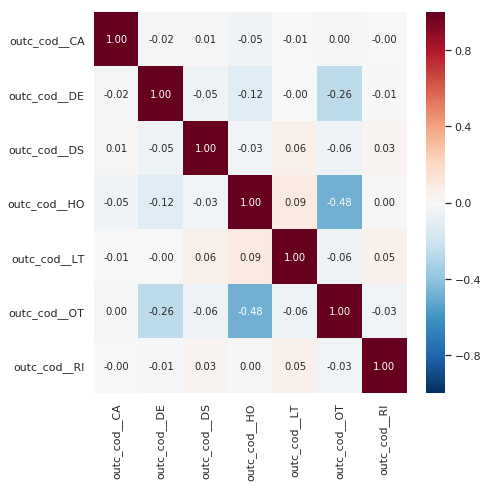

In [47]:
%%time

# formatted heatmap of multilabel correlation matrix
def hmap_corr(targets, imgname):
    '''Formated heatmap of multilabel outcomes correlation matrix'''
    ncol = targets.shape[1]
    fig, ax = plt.subplots(figsize=(ncol,ncol))
    ax = sns.heatmap(
        targets.corr(),
        fmt='.2f',
        annot=True,
        ax=ax,
        cmap='RdBu_r',
        vmin=-1,
        vmax=1,
    )
    
    fig.savefig(
        imgname,
        dpi=300,
        bbox_inches='tight',
    )
    
    
if __name__=='__main__':
    hmap_corr(y, 'hmap_corr.png')
    


In [46]:
ncol = y_df.shape[1]
print(ncol)

7


CPU times: user 2.86 s, sys: 458 ms, total: 3.32 s
Wall time: 3.23 s


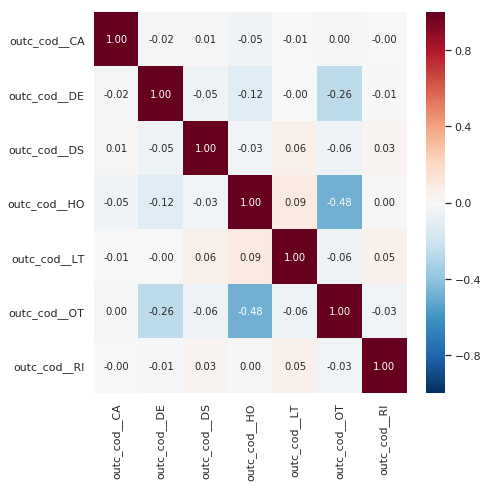

In [48]:
%%time

# convert array to df for heatmap of correlations
y_cols = ['outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 
          'outc_cod__LT', 'outc_cod__OT',  'outc_cod__RI']
y_df = pd.DataFrame(y_arr, columns=y_cols)

if __name__=='__main__':
    hmap_corr(y, 'hmap_corr2.png')



## ML Pipeline - Model Selection step

In [5]:
%%time

# 6. ml clf model eval
def ml_clf_eval():
    """Pipeline to evaluate multilabel classifiers prior to hyperparameter tuning."""
    for classifier in classifiers:
        ml_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', MultiOutputClassifier(classifier))
                                 ]
                          )
        with joblib.parallel_backend('dask'):
            ml_clf = ml_pipe.fit(X_train, y_train)
        
        y_pred = ml_clf.predict(X_test)
        print('y_pred\n', y_pred.shape,'\n',y_pred[3:],'\n')

        print(f'Multilabel Classifier: {classifier} Performance Metrics:\n')
        # accuracy, hamming loss and jaccard score for mlabel
        print('accuracy: ', accuracy_score(y_test, y_pred))
        print('hamming loss: ', hamming_loss(y_test, y_pred))
        print('jaccard score: ', jaccard_score(y_test, y_pred, average='micro'))
        print('roc auc score: ', roc_auc_score(y_test, y_pred))
        print('average precision score: ', average_precision_score(y_test, y_pred),'\n')

        # generate ml cm
        multilabel_cm = multilabel_confusion_matrix(y_test, y_pred)
        # calc tp, tn, fp, fn rates
        tp = multilabel_cm[:, 0, 0]
        tn = multilabel_cm[:, 1, 1]
        fp = multilabel_cm[:, 0, 1]
        fn = multilabel_cm[:, 1, 0]

        outc_labels = ['outc_cod__CA','outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT', 
                       'outc_cod__OT',  'outc_cod__RI']
        print('Recall, Specificity, Fall Out and Miss Rate for Multilabel Adverse Event Outcomes:\n', outc_labels)
        # recall
        print('recall (true pos rate):\n', tp / (tp + fn))
        # specificity
        print('specificity (true neg rate):\n', tn / (tn + fp))
        # fall out
        print('fall out (false pos rate):\n', fp / (fp + tn))
        # miss rate
        print('miss rate (false neg rate):\n', fn / (fn + tp), '\n')

        # plot multilabel confusion matrix
        def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
            df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names) 
            try:
                heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap="YlGnBu")  #cmap='RdBu_r', 
            except ValueError:
                raise ValueError("Confusion matrix values must be integers.")
            heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', 
                                         fontsize=fontsize)
            heatmap.xaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', 
                                         fontsize=fontsize)
            axes.set_xlabel('True label')
            axes.set_ylabel('Predicted label')
            axes.set_title("Confusion matrix for class - " + class_label)

        # plot grid of cm's - one per output - raw
        fig, ax = plt.subplots(3, 3, figsize=(12, 7))

        for axes, cfs_matrix, label in zip(ax.flatten(), multilabel_cm, outc_labels):  # labels):
            print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

        fig.tight_layout()
        plt.show()
        
        
        # corr matrix heatmap 
        y_df = pd.DataFrame(y_pred, columns=outc_labels)
        ncol = y_df.shape[1]
        fig, ax = plt.subplots(figsize=(ncol,ncol))
        ax = sns.heatmap(y_df.corr(), fmt='.2f', annot=True, ax=ax, cmap='RdBu_r', vmin=-1, vmax=1)
        imgname = str(classifiers[0]) + '-hmap_corr.png'
        fig.savefig(imgname, dpi=300, bbox_inches='tight')
        print('Correlation Matrix Heatmap of Predicted Multilabel Adverse Events\n')
        plt.show()
    

CPU times: user 17 µs, sys: 3 µs, total: 20 µs
Wall time: 39.1 µs


In [56]:
# 5a. create list of classifiers to test - can select by commenting out clf not run
#classifiers = [RandomForestClassifier(class_weight='balanced')]

classifiers = [   
    #RidgeClassifierCV(class_weight='balanced'),
    DecisionTreeClassifier(class_weight='balanced'),
    #ExtraTreesClassifier(class_weight='balanced'),
    #RandomForestClassifier(class_weight='balanced'),
    #MLPClassifier(solver='sdg', learning_rate='adaptive', early_stopping=True),
    #KNeighborsClassifier(weights='distance'),
    #RadiusNeighborsClassifier(weights='distance')
]

print(classifiers[0])
strname = str(classifiers)
print(str(classifiers[0]) + '-hmap_corr.png')

DecisionTreeClassifier(class_weight='balanced')
DecisionTreeClassifier(class_weight='balanced')-hmap_corr.png


y_pred
 (78215, 7) 
 [[0 1 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 1 ... 0 1 0]
 ...
 [0 1 0 ... 1 1 0]
 [0 0 1 ... 1 1 0]
 [0 1 1 ... 0 1 0]] 

Multilabel Classifier: DecisionTreeClassifier(class_weight='balanced') Performance Metrics:

accuracy:  0.3263056958383942
hamming loss:  0.18149971233139423
jaccard score:  0.3910357760047064
roc auc score:  0.6884587334931574
average precision score:  0.25372686573840647 

Recall, Specificity, Fall Out and Miss Rate for Multilabel Adverse Event Outcomes:
 ['outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI']
recall (true pos rate):
 [0.9978039  0.91993286 0.98207336 0.74447257 0.97653274 0.4983104
 0.99900902]
specificity (true neg rate):
 [0.04177393 0.30065157 0.09340659 0.67810771 0.21920776 0.75332254
 0.04669261]
fall out (false pos rate):
 [0.95822607 0.69934843 0.90659341 0.32189229 0.78079224 0.24667746
 0.95330739]
miss rate (false neg rate):
 [0.0021961  0.08006714 0.01792664

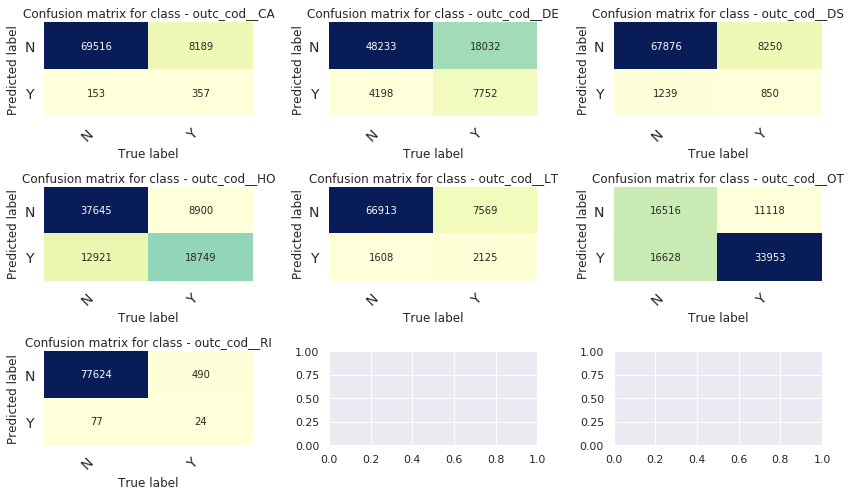

Correlation Matrix Heatmap of Predicted Multilabel Adverse Events



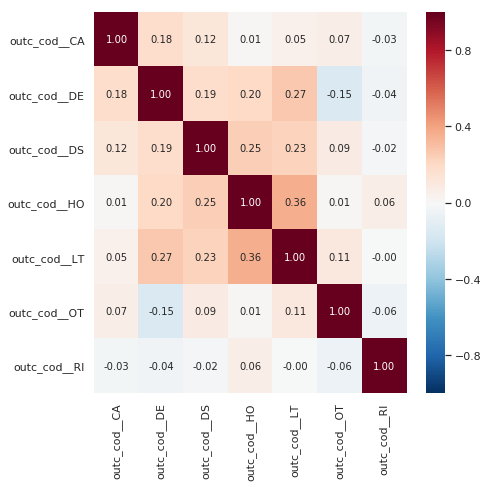

CPU times: user 1min 8s, sys: 7.43 s, total: 1min 15s
Wall time: 2min 19s


In [77]:
classifiers = [   
    #RidgeClassifierCV(class_weight='balanced'),
    DecisionTreeClassifier(class_weight='balanced'),
    #ExtraTreesClassifier(class_weight='balanced'),
    #RandomForestClassifier(class_weight='balanced'),
    #MLPClassifier(solver='sdg', learning_rate='adaptive', early_stopping=True),
    #KNeighborsClassifier(weights='distance'),
    #RadiusNeighborsClassifier(weights='distance')
]
    
# 8. Run model eval
if __name__ == '__main__':
    ml_clf_eval()

[RandomForestClassifier(class_weight='balanced')]
y_pred
 (78215, 7) 
 [[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 1 ... 0 1 0]
 ...
 [0 1 0 ... 1 1 0]
 [0 0 1 ... 0 1 0]
 [0 1 1 ... 0 1 0]] 

Multilabel Classifier: RandomForestClassifier(class_weight='balanced') Performance Metrics:

accuracy:  0.3659656076200217
hamming loss:  0.1657427786047616
jaccard score:  0.4138525733774287
roc auc score:  0.6883043183591219
average precision score:  0.26072600543069957 

Recall, Specificity, Fall Out and Miss Rate for Multilabel Adverse Event Outcomes:
 ['outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI']
recall (true pos rate):
 [0.99772795 0.91714843 0.98122699 0.74792434 0.97536489 0.50773388
 0.99900939]
specificity (true neg rate):
 [0.04745717 0.31170244 0.11808    0.69241537 0.27913203 0.75473174
 0.04948454]
fall out (false pos rate):
 [0.95254283 0.68829756 0.88192    0.30758463 0.72086797 0.24526826
 0.95051546]
miss rate (f

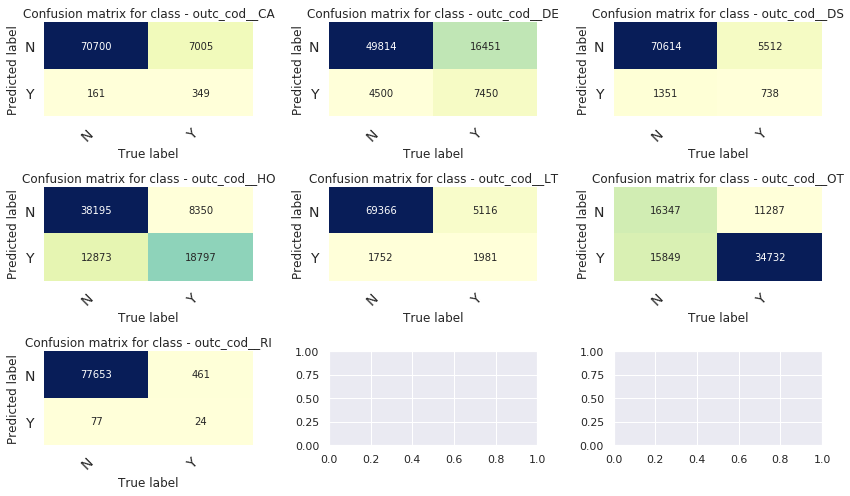

Correlation Matrix Heatmap of Predicted Multilabel Adverse Events



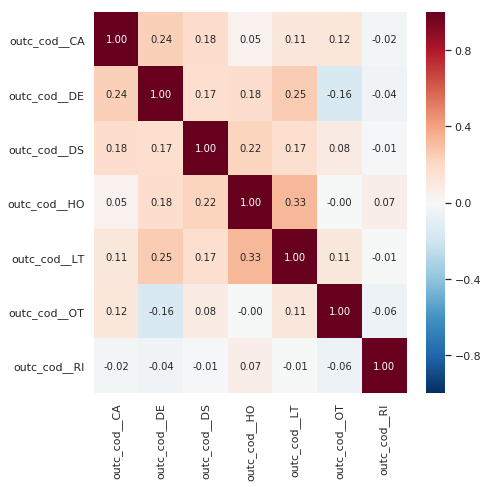

In [78]:
# 5b. create list of classifiers to test - can select by commenting out clf not run
#classifiers = [RandomForestClassifier(class_weight='balanced')]

classifiers = [   
    #RidgeClassifierCV(class_weight='balanced'),
    #DecisionTreeClassifier(class_weight='balanced'),
    #ExtraTreesClassifier(class_weight='balanced'),
    RandomForestClassifier(class_weight='balanced'),
    #MLPClassifier(solver='sdg', learning_rate='adaptive', early_stopping=True),
    #KNeighborsClassifier(weights='distance'),
    #RadiusNeighborsClassifier(weights='distance')
]

print(classifiers)

# 8. Run model eval
if __name__ == '__main__':
    ml_clf_eval()

[RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight='balanced')]
y_pred
 (78215, 7) 
 [[0 1 1 ... 1 1 0]
 [1 1 0 ... 1 1 0]
 [1 1 1 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]] 

Multilabel Classifier: RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight='balanced') Performance Metrics:

accuracy:  0.14590551684459502
hamming loss:  0.21750121003461156
jaccard score:  0.32667831436341943
roc auc score:  0.7562266183272204
average precision score:  0.25664328270550724 

Recall, Specificity, Fall Out and Miss Rate for Multilabel Adverse Event Outcomes:
 ['outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI']
recall (true pos rate):
 [0.99847345 0.90813019 0.98761662 0.72738245 0.98457548 0.47440324
 1.        ]
specificity (true neg rate):
 [0.03143007 0.29336043 0.07263883 0.70927169 0.20545806 0.77215091
 0.03069196]
fall out (false pos rate):
 [0.96856993 0.70663957 0.927361

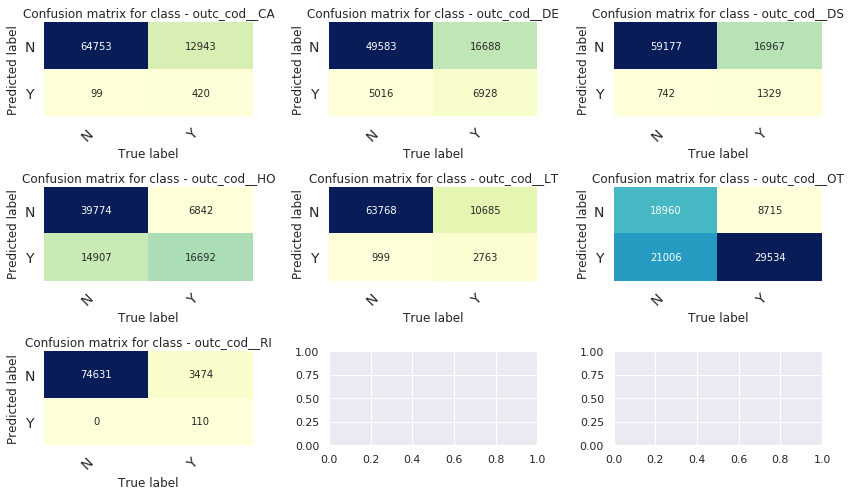

Correlation Matrix Heatmap of Predicted Multilabel Adverse Events



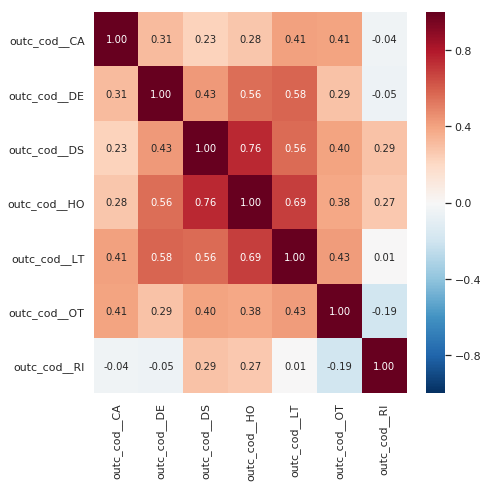

In [6]:
# 5c. create list of classifiers to test - can select by commenting out clf not run
#classifiers = [RandomForestClassifier(class_weight='balanced')]

classifiers = [   
    RidgeClassifierCV(class_weight='balanced'),
    #DecisionTreeClassifier(class_weight='balanced'),
    #ExtraTreesClassifier(class_weight='balanced'),
    #RandomForestClassifier(class_weight='balanced'),
    #MLPClassifier(solver='sdg')  #, learning_rate='adaptive', early_stopping=True),
    #KNeighborsClassifier(weights='distance'),
    #RadiusNeighborsClassifier(weights='distance')
]

print(classifiers)

# 8. Run model eval
if __name__ == '__main__':
    ml_clf_eval()

In [7]:
# 5c. create list of classifiers to test - can select by commenting out clf not run
#classifiers = [RandomForestClassifier(class_weight='balanced')]

classifiers = [   
    #RidgeClassifierCV(class_weight='balanced'),
    #DecisionTreeClassifier(class_weight='balanced'),
    #ExtraTreesClassifier(class_weight='balanced'),
    #RandomForestClassifier(class_weight='balanced'),
    #MLPClassifier(solver='sdg')  #, learning_rate='adaptive', early_stopping=True),
    KNeighborsClassifier(weights='distance'),
    #RadiusNeighborsClassifier(weights='distance')
]

print(classifiers)

# 8. Run model eval
if __name__ == '__main__':
    ml_clf_eval()

[KNeighborsClassifier(weights='distance')]


tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0xa0f6c978>, <Future finished exception=TypeError('cannot unpack non-iterable coroutine object')>)
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/joblib/_dask.py", line 182, in maybe_to_futures
    f = call_data_futures[arg]
  File "/usr/lib/python3/dist-packages/joblib/_dask.py", line 48, in __getitem__
    ref, val = self._data[id(obj)]
KeyError: 2642435432

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/lib/python3/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/tornado/ioloop.py", line 779, in _discard_future_result
    future.result()
  File "/usr/lib/python3/dist-packages/tornado/gen.

KeyboardInterrupt: 

In [ ]:
# 5c. create list of classifiers to test - can select by commenting out clf not run
#classifiers = [RandomForestClassifier(class_weight='balanced')]

classifiers = [   
    #RidgeClassifierCV(class_weight='balanced'),
    #DecisionTreeClassifier(class_weight='balanced'),
    #ExtraTreesClassifier(class_weight='balanced'),
    #RandomForestClassifier(class_weight='balanced'),
    #MLPClassifier(solver='sdg')  #, learning_rate='adaptive', early_stopping=True),
    #KNeighborsClassifier(weights='distance'),
    RadiusNeighborsClassifier(weights='distance')
]

print(classifiers)

# 8. Run model eval
if __name__ == '__main__':
    ml_clf_eval()

In [8]:
# 5c. create list of classifiers to test - can select by commenting out clf not run
#classifiers = [RandomForestClassifier(class_weight='balanced')]

classifiers = [   
    #RidgeClassifierCV(class_weight='balanced'),
    #DecisionTreeClassifier(class_weight='balanced'),
    ExtraTreesClassifier(class_weight='balanced'),
    #RandomForestClassifier(class_weight='balanced'),
    #MLPClassifier(solver='sdg')  #, learning_rate='adaptive', early_stopping=True),
    #KNeighborsClassifier(weights='distance'),
    #RadiusNeighborsClassifier(weights='distance')
]

print(classifiers)

# 8. Run model eval
if __name__ == '__main__':
    ml_clf_eval()

[ExtraTreesClassifier(class_weight='balanced')]


KeyboardInterrupt: 

In [ ]:
# 5c. create list of classifiers to test - can select by commenting out clf not run
#classifiers = [RandomForestClassifier(class_weight='balanced')]

classifiers = [   
    #RidgeClassifierCV(class_weight='balanced'),
    #DecisionTreeClassifier(class_weight='balanced'),
    #ExtraTreesClassifier(class_weight='balanced'),
    #RandomForestClassifier(class_weight='balanced'),
    MLPClassifier(solver='sdg')  #, learning_rate='adaptive', early_stopping=True),
    #KNeighborsClassifier(weights='distance'),
    #RadiusNeighborsClassifier(weights='distance')
]

print(classifiers)

# 8. Run model eval
if __name__ == '__main__':
    ml_clf_eval()

# STOPPED HERE - 2.13.2021

## ML Pipeline - Hyperparameter Tuning step

In [ ]:
# 9. hyperparameter tuning of best performing clfs

# ridgeCV grid search
param_grid = {
    'classifier__alphas': [0.0001, 0.001, 0.01, 0.1]
}

# USE STRATIFIEDKFOLD FOR CV TUNE HYPERPARAMETERS USING APPROPRIATE METRICS (E.G. AUC)

#RidgeClassifierCV(alphas=param_grid, class_weight='balanced')

#CV = GridSearchCV()

# STOPPED HERE - 2.6.2021
## TODOs:
1. Update HP tuning to use StratifiedKFold with appropriate metrics (e.g. AUC, ...)
2. Adapt plot_roc_crossval code below for multilabel outcomes

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with

'''
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]'''

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

'''classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)'''

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

y_pred
 (78215, 7) 
 [[0 1 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 1 ... 0 1 0]
 ...
 [0 1 0 ... 1 1 0]
 [0 0 1 ... 1 1 0]
 [0 1 1 ... 0 1 0]] 

Multilabel Classifier: DecisionTreeClassifier(class_weight='balanced') Performance Metrics:

accuracy:  0.32652304545163974
hamming loss:  0.1814339595072191
jaccard score:  0.39118923291902624
roc auc score:  0.6887447775705817
average precision score:  0.25387762753849386 

Recall, Specificity, Fall Out and Miss Rate for Multilabel Adverse Event Outcomes:
 ['outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI']
recall (true pos rate):
 [0.99781819 0.92002213 0.98206044 0.74456726 0.97661928 0.49837055
 0.99900902]
specificity (true neg rate):
 [0.04188114 0.30079882 0.09335826 0.67838796 0.21975869 0.75334443
 0.04669261]
fall out (false pos rate):
 [0.95811886 0.69920118 0.90664174 0.32161204 0.78024131 0.24665557
 0.95330739]
miss rate (false neg rate):
 [0.00218181 0.07997787 0.017939

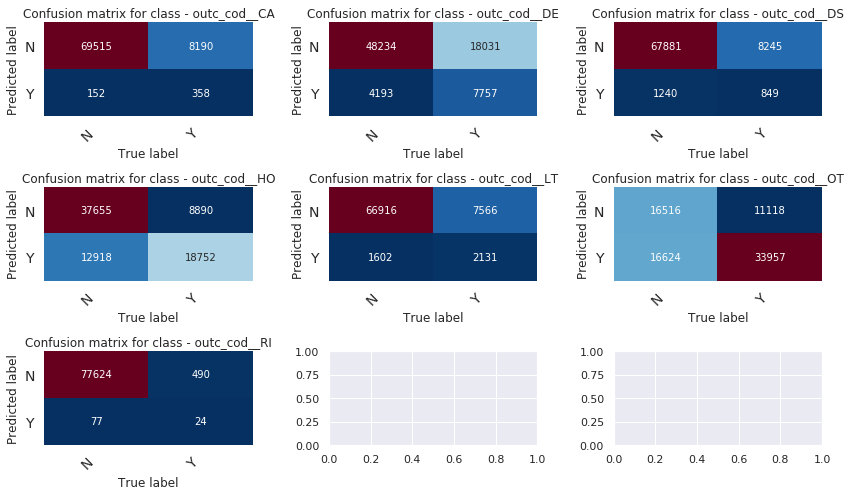

Correlation Matrix Heatmap of Predicted Multilabel Adverse Events



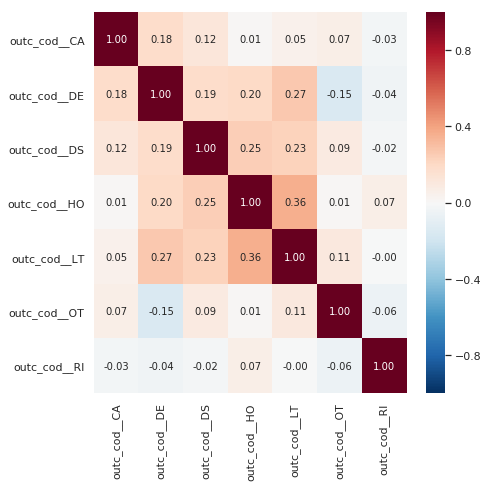

In [76]:
# different cmap for plots

# 6. ml clf model eval
def ml_clf_eval():
    """Pipeline to evaluate multilabel classifiers prior to hyperparameter tuning."""
    for classifier in classifiers:
        ml_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', MultiOutputClassifier(classifier))
                                 ]
                          )
        with joblib.parallel_backend('dask'):
            ml_clf = ml_pipe.fit(X_train, y_train)
        
        y_pred = ml_clf.predict(X_test)
        print('y_pred\n', y_pred.shape,'\n',y_pred[3:],'\n')

        print(f'Multilabel Classifier: {classifier} Performance Metrics:\n')
        # accuracy, hamming loss and jaccard score for mlabel
        print('accuracy: ', accuracy_score(y_test, y_pred))
        print('hamming loss: ', hamming_loss(y_test, y_pred))
        print('jaccard score: ', jaccard_score(y_test, y_pred, average='micro'))
        print('roc auc score: ', roc_auc_score(y_test, y_pred))
        print('average precision score: ', average_precision_score(y_test, y_pred),'\n')

        # generate ml cm
        multilabel_cm = multilabel_confusion_matrix(y_test, y_pred)
        # calc tp, tn, fp, fn rates
        tp = multilabel_cm[:, 0, 0]
        tn = multilabel_cm[:, 1, 1]
        fp = multilabel_cm[:, 0, 1]
        fn = multilabel_cm[:, 1, 0]

        outc_labels = ['outc_cod__CA','outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT', 
                       'outc_cod__OT',  'outc_cod__RI']
        print('Recall, Specificity, Fall Out and Miss Rate for Multilabel Adverse Event Outcomes:\n', outc_labels)
        # recall
        print('recall (true pos rate):\n', tp / (tp + fn))
        # specificity
        print('specificity (true neg rate):\n', tn / (tn + fp))
        # fall out
        print('fall out (false pos rate):\n', fp / (fp + tn))
        # miss rate
        print('miss rate (false neg rate):\n', fn / (fn + tp), '\n')

        # plot multilabel confusion matrix
        def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
            df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names) 
            try:
                heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap="YlGnBu")  #cmap='RdBu_r', 
            except ValueError:
                raise ValueError("Confusion matrix values must be integers.")
            heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', 
                                         fontsize=fontsize)
            heatmap.xaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', 
                                         fontsize=fontsize)
            axes.set_xlabel('True label')
            axes.set_ylabel('Predicted label')
            axes.set_title("Confusion matrix for class - " + class_label)

        # plot grid of cm's - one per output - raw
        fig, ax = plt.subplots(3, 3, figsize=(12, 7))

        for axes, cfs_matrix, label in zip(ax.flatten(), multilabel_cm, outc_labels):  # labels):
            print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

        fig.tight_layout()
        plt.show()
        
        
        # corr matrix heatmap 
        y_df = pd.DataFrame(y_pred, columns=outc_labels)
        ncol = y_df.shape[1]
        fig, ax = plt.subplots(figsize=(ncol,ncol))
        ax = sns.heatmap(y_df.corr(), fmt='.2f', annot=True, ax=ax, cmap='RdBu_r', vmin=-1, vmax=1)
        imgname = str(classifiers[0]) + '-hmap_corr.png'
        fig.savefig(imgname, dpi=300, bbox_inches='tight')
        print('Correlation Matrix Heatmap of Predicted Multilabel Adverse Events\n')
        plt.show()
    
    
# 8. Run model eval
if __name__ == '__main__':
    ml_clf_eval()

## ML Pipeline - Model Deployment step

In [ ]:
# 10. save model object (pickle + copyreg or joblib to serialize model config and parameters)

# 11. load model object and score new data

# 12. create profiling plots of predicted scores to show relationships with features 
#     (e.g. key drivers of different AE outcomes)


# STOPPED HERE - 2.5.2021